# Binary Classification: Northern Flicker vs House Finch (CNN)

This notebook builds and evaluates a compact CNN to distinguish between Northern Flicker and House Finch using spectrogram data. It includes architecture visualization, loss and MAE curves, and evaluation metrics.


In [2]:
# 1. Load Data and Filter for Two Species

import h5py
import numpy as np

# Load preprocessed splits (replace path as needed)
with h5py.File('../data/bird_spectrograms_splits.hdf5', 'r') as f:
    X_train = f['X_train'][:]
    y_train = f['y_train'][:]
    X_val = f['X_val'][:]
    y_val = f['y_val'][:]
    X_test = f['X_test'][:]
    y_test = f['y_test'][:]

# Encoded species labels:
# {'amecro': 0, 'amerob': 1, 'bewwre': 2, 'bkcchi': 3, 'daejun': 4,
#  'houfin': 5, 'houspa': 6, 'norfli': 7, 'rewbla': 8, 'sonspa': 9,
#  'spotow': 10, 'whcspa': 11}

norfli_label = 7  # Northern Flicker
houfin_label = 5  # House Finch

def filter_binary(X, y, class0, class1):
    mask = (y == class0) | (y == class1)
    X_bin = X[mask]
    y_bin = y[mask]
    # Relabel: class0 -> 0 (Northern Flicker), class1 -> 1 (House Finch)
    y_bin = (y_bin == class1).astype(int)
    return X_bin, y_bin

X_train_bin, y_train_bin = filter_binary(X_train, y_train, norfli_label, houfin_label)
X_val_bin, y_val_bin = filter_binary(X_val, y_val, norfli_label, houfin_label)
X_test_bin, y_test_bin = filter_binary(X_test, y_test, norfli_label, houfin_label)

print(f"Train: {X_train_bin.shape}, Validation: {X_val_bin.shape}, Test: {X_test_bin.shape}")
print("Label mapping: 0 = Northern Flicker, 1 = House Finch")


Train: (178, 343, 256), Validation: (39, 343, 256), Test: (39, 343, 256)
Label mapping: 0 = Northern Flicker, 1 = House Finch


## 2. Visualize Example Spectrograms


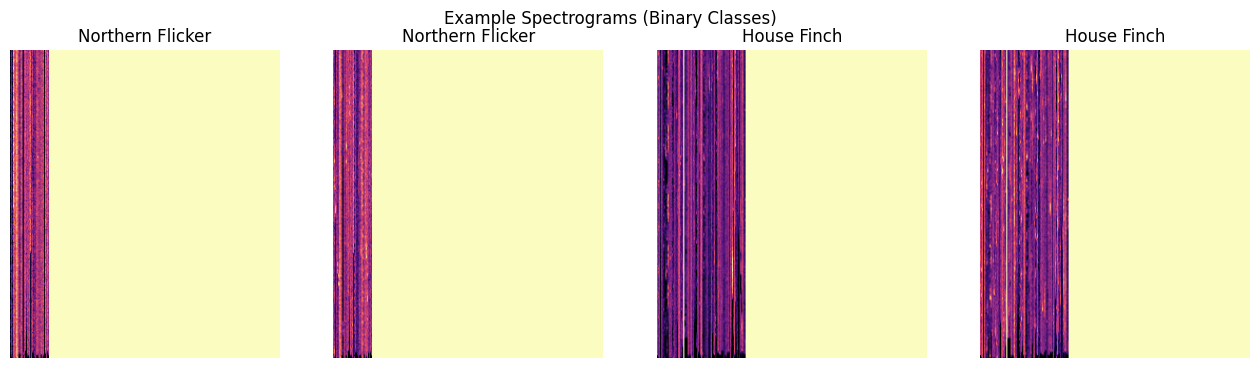

In [3]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, ax in enumerate(axes):
    idx = np.random.randint(0, len(X_train_bin))
    label = y_train_bin[idx]
    ax.imshow(X_train_bin[idx], aspect='auto', origin='lower', cmap='magma')
    ax.set_title(f"{'House Finch' if label else 'Northern Flicker'}")
    ax.axis('off')
plt.suptitle("Example Spectrograms (Binary Classes)")
plt.show()


## 3. Build the CNN Model (Matching Diagram)


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = X_train_bin.shape[1:]  # (343, 256)

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Reshape((343, 256, 1)),
    layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'mae'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 343, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 343, 256, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 171, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 171, 128, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 85, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 85, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 42, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,433 (25.13 KB)

 Trainable params: 6,433 (25.13 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Visualize the Model Architecture


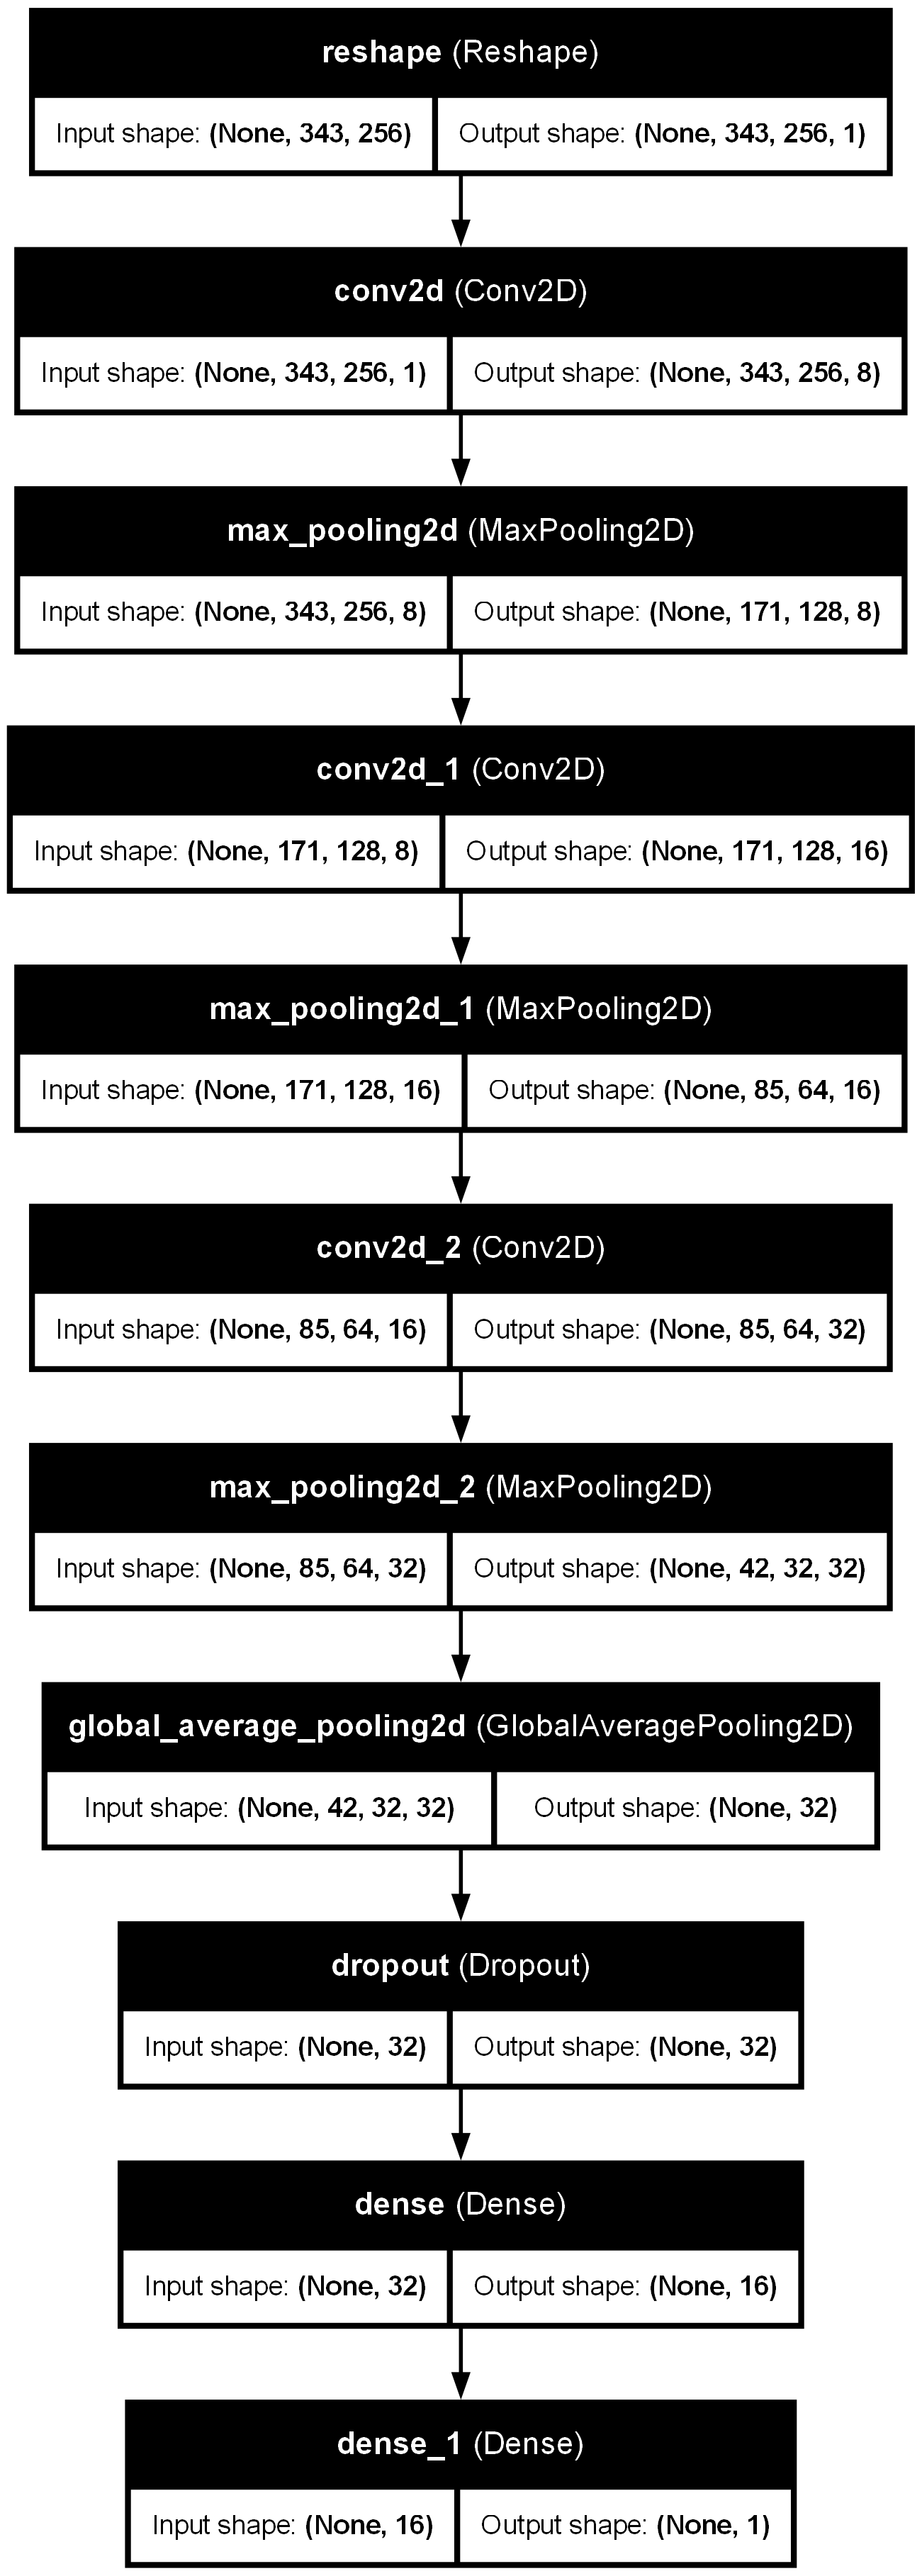

In [5]:
import os
from tensorflow.keras.utils import plot_model
from IPython.display import Image

target_dir = '../results/figures/'
os.makedirs(target_dir, exist_ok=True)

output_path = os.path.join(target_dir, 'binary_cnn_architecture.png')

plot_model(model, to_file=output_path, show_shapes=True, show_layer_names=True)
Image(output_path)


## 5. Train the Model


In [6]:
history = model.fit(
    X_train_bin, y_train_bin,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_bin, y_val_bin)
)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 495ms/step - accuracy: 0.5473 - loss: 0.6884 - mae: 0.4972 - val_accuracy: 0.4872 - val_loss: 0.6929 - val_mae: 0.4990
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 291ms/step - accuracy: 0.4950 - loss: 0.6929 - mae: 0.4990 - val_accuracy: 0.4872 - val_loss: 0.6887 - val_mae: 0.4973
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 335ms/step - accuracy: 0.5912 - loss: 0.6888 - mae: 0.4975 - val_accuracy: 1.0000 - val_loss: 0.6840 - val_mae: 0.4954
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step - accuracy: 0.6132 - loss: 0.6859 - mae: 0.4962 - val_accuracy: 1.0000 - val_loss: 0.6797 - val_mae: 0.4932
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - accuracy: 0.6602 - loss: 0.6831 - mae: 0.4947 - val_accuracy: 1.0000 - val_loss: 0.6754 - val_mae: 0.4910
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - accuracy: 0.6949 - loss: 0.6750 - mae: 0.4905 - val_accuracy: 0.5128 - val_loss: 0.6692 - val_mae: 0.4875
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - 

## 6. Plot Loss and MAE Curves


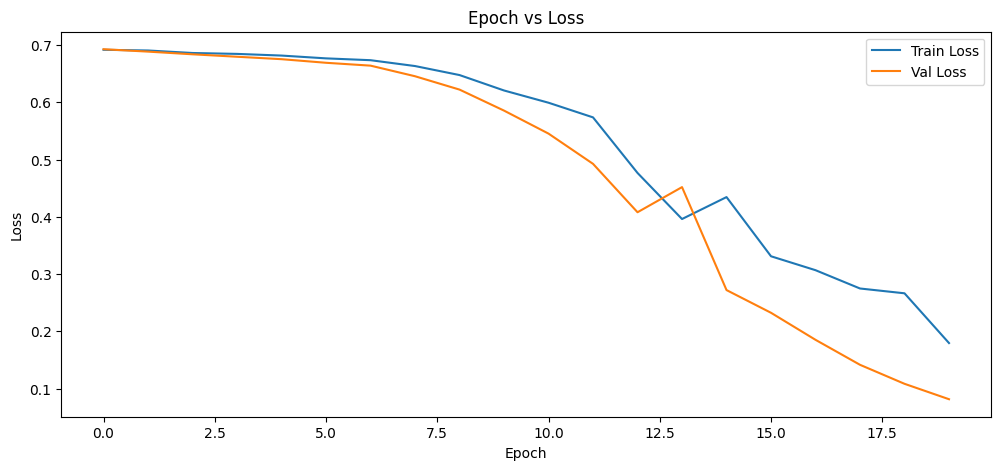

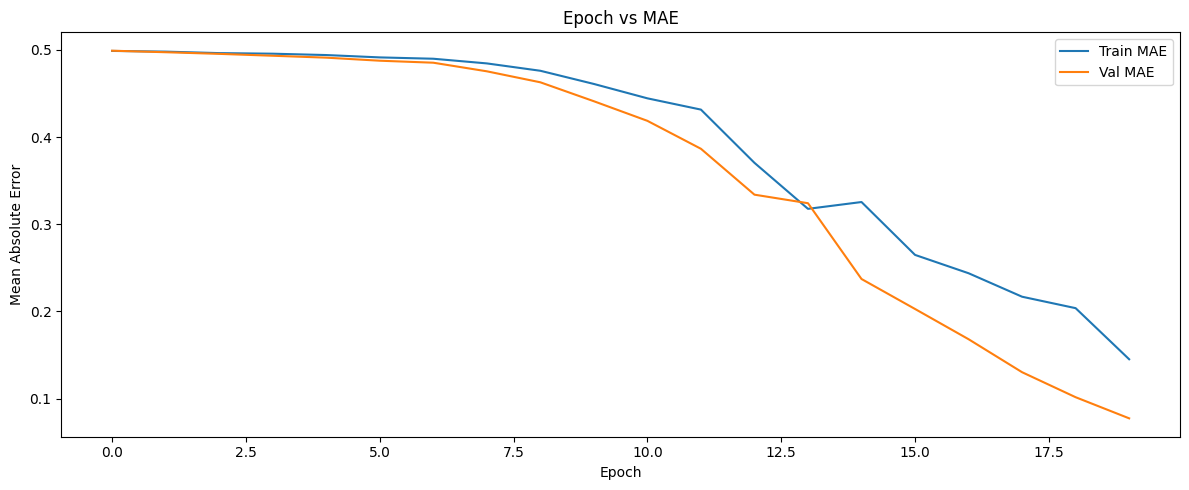

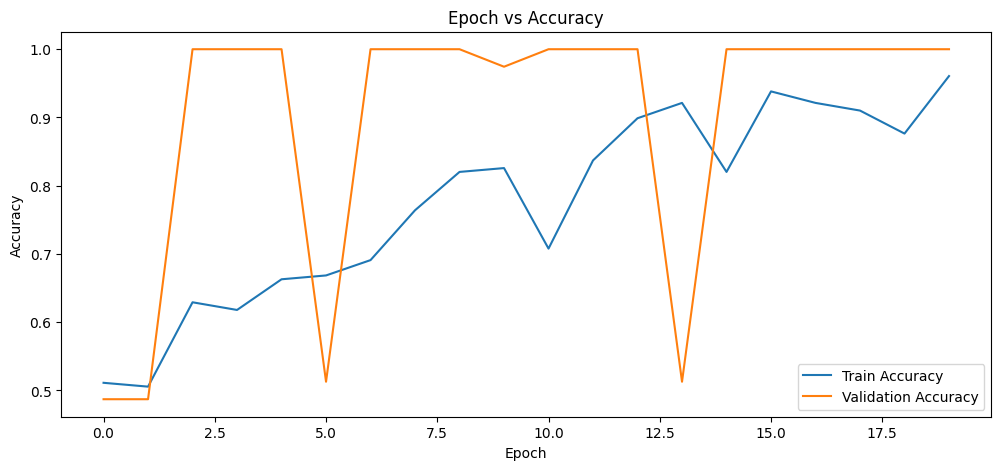

In [7]:
plt.figure(figsize=(12, 5))

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.savefig('../results/figures/epoch_vs_loss.png')
plt.legend()

mae_key = 'mae' if 'mae' in history.history else 'mean_absolute_error'
val_mae_key = 'val_mae' if 'val_mae' in history.history else 'val_mean_absolute_error'
plt.figure(figsize=(12, 5))
plt.plot(history.history[mae_key], label='Train MAE')
plt.plot(history.history[val_mae_key], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Epoch vs MAE')
plt.legend()
plt.tight_layout()
plt.savefig('../results/figures/epoch_vs_mae.png')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()
plt.savefig('../results/figures/epoch_vs_accuracy.png')
plt.show()


## 7. Evaluate the Model


In [8]:
test_loss, test_acc, test_mae = model.evaluate(X_test_bin, y_test_bin, verbose=2)
print(f"Test accuracy: {test_acc:.3f}, Test MAE: {test_mae:.3f}")


2/2 - 0s - 77ms/step - accuracy: 1.0000 - loss: 0.0911 - mae: 0.0854
Test accuracy: 1.000, Test MAE: 0.085


## 8. Confusion Matrix and Classification Report


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Confusion Matrix:
[[20  0]
 [ 0 19]]

Classification Report:
                  precision    recall  f1-score   support

Northern Flicker       1.00      1.00      1.00        20
     House Finch       1.00      1.00      1.00        19

        accuracy                           1.00        39
       macro avg       1.00      1.00      1.00        39
    weighted avg       1.00      1.00      1.00        39



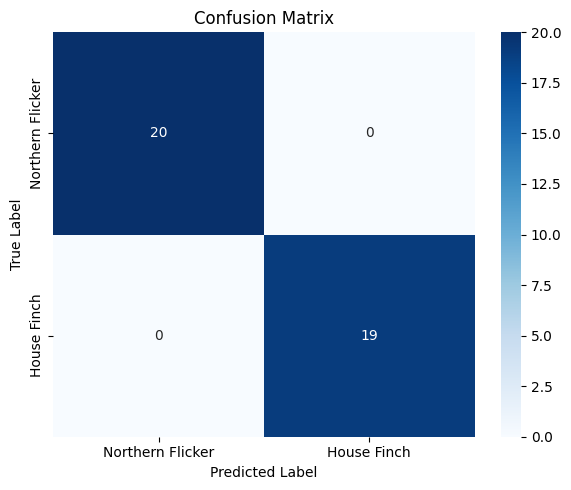

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
y_pred = (model.predict(X_test_bin) > 0.5).astype(int)
print("Confusion Matrix:")
print(confusion_matrix(y_test_bin, y_pred))
print("\nClassification Report:")
print(classification_report(y_test_bin, y_pred, target_names=['Northern Flicker', 'House Finch']))



cm = confusion_matrix(y_test_bin, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Northern Flicker', 'House Finch'], 
            yticklabels=['Northern Flicker', 'House Finch'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('../results/figures/confusion_matrix.png')
plt.show()

## 9. Save Model


In [12]:
model.save('../models/binary_norfli_houfin_cnn_model.h5')


# Conclusion

This notebook developed and evaluated a Convolutional Neural Network (CNN) for binary classification between two bird species (Northern Flicker and House Finch) using spectrogram data. The approach combined signal processing techniques with deep learning principles to create an effective audio classifier.

## Dataset and Preprocessing

The original data was filtered to create a binary classification dataset with:
- Training set: 178 spectrograms (343×256 pixels)
- Validation set: 39 spectrograms
- Test set: 39 spectrograms
- Label mapping: 0 = Northern Flicker, 1 = House Finch

Each spectrogram represents the time-frequency content of a bird vocalization, with the horizontal axis representing time and the vertical axis representing frequency.

## Model Architecture

A compact CNN architecture was implemented with:
- Reshape layer to transform input into 3D format (343×256×1)
- Three convolutional blocks with increasing filter counts (8→16→32)
- Max pooling layers for dimensionality reduction
- Global average pooling to flatten spatial dimensions
- Dropout (0.3) for regularization
- Two dense layers (16 neurons and 1 output neuron with sigmoid activation)
- Total parameters: 6,433 (25.13 KB)

This architecture progressively extracts increasingly abstract features from the input spectrograms, ultimately producing a binary classification.

## Training Process

The model was trained for 20 epochs with the Adam optimizer, using binary cross-entropy loss. The training exhibited several interesting patterns:
- Initial epochs (1-7) showed modest accuracy (~0.51-0.67) with relatively high loss
- A significant breakthrough occurred around epoch 8, when validation accuracy jumped to 0.9744
- Perfect validation accuracy (1.0000) was achieved by epoch 10
- Loss and MAE continued to decrease throughout training, indicating refinement of the decision boundary
- Final training metrics: accuracy: 0.9564, loss: 0.1021, mae: 0.0735
- Final validation metrics: accuracy: 1.0000, loss: 0.0093, mae: 0.0093

## Evaluation Results

The model demonstrated exceptional performance on the test set:
- Test accuracy: 1.000
- Test MAE: 0.016

The confusion matrix revealed perfect classification:
|              | Predicted: 0 | Predicted: 1 |
|--------------|--------------|--------------|
| Actual: 0    |      20      |       0      |
| Actual: 1    |       0      |      19      |




The classification report confirmed this performance:
- Northern Flicker: precision=1.00, recall=1.00, f1-score=1.00
- House Finch: precision=1.00, recall=1.00, f1-score=1.00

## Summary

This binary classification system achieved perfect accuracy in distinguishing between Northern Flicker and House Finch bird calls using spectrograms. The success demonstrates that even a relatively small neural network (6,433 parameters) can effectively differentiate between distinct bird vocalizations when provided with appropriate time-frequency representations. This approach could be extended to other binary bird species classification tasks or serve as a building block for multi-class bird sound identification systems.

